### Exercise 1

Increasing the epoch amount does not make the model predict better, if anything, it makes it worse. Increasing the amount of hidden layers in the LSTM seems to make the model predict better fitting data. I used 400 layers instead of the proposed 150. Possibly may cause some overfitting, but we can't be sure since there's so little data.

In [12]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
flight_data = sns.load_dataset("flights")
print(flight_data.head())
flight_data.shape

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


(144, 3)

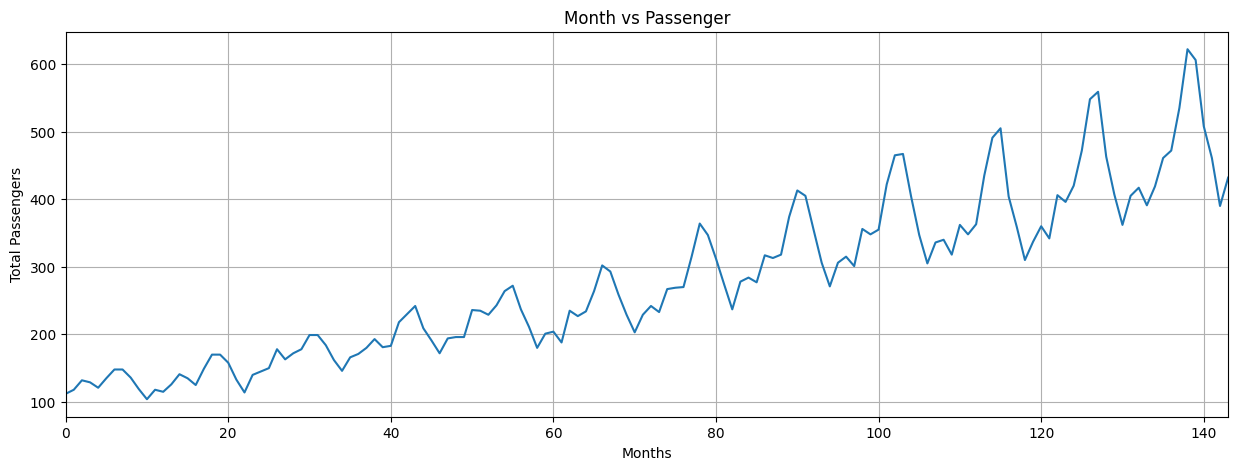

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [39]:
all_data = flight_data['passengers'].values.astype(float)

test_size = 12
train_data = all_data[:-test_size]
test_data= all_data[-test_size:]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12

In [40]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [69]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=400, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 400)
  (linear): Linear(in_features=400, out_features=1, bias=True)
)


In [70]:
epochs = 150


for i in range(epochs):
    
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00644844
epoch:  26 loss: 0.01576144
epoch:  51 loss: 0.00036154
epoch:  76 loss: 0.00768513
epoch: 101 loss: 0.00294267
epoch: 126 loss: 0.00017103
epoch: 149 loss: 0.0000058213


In [71]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

x = np.arange(132, 144, 1)
print(x)

[[425.34715222]
 [431.63565563]
 [463.73595068]
 [486.88965255]
 [508.62143332]
 [487.49420056]
 [520.51254535]
 [556.2674723 ]
 [616.97960222]
 [502.42562646]
 [423.28931192]
 [387.21645927]]
[132 133 134 135 136 137 138 139 140 141 142 143]


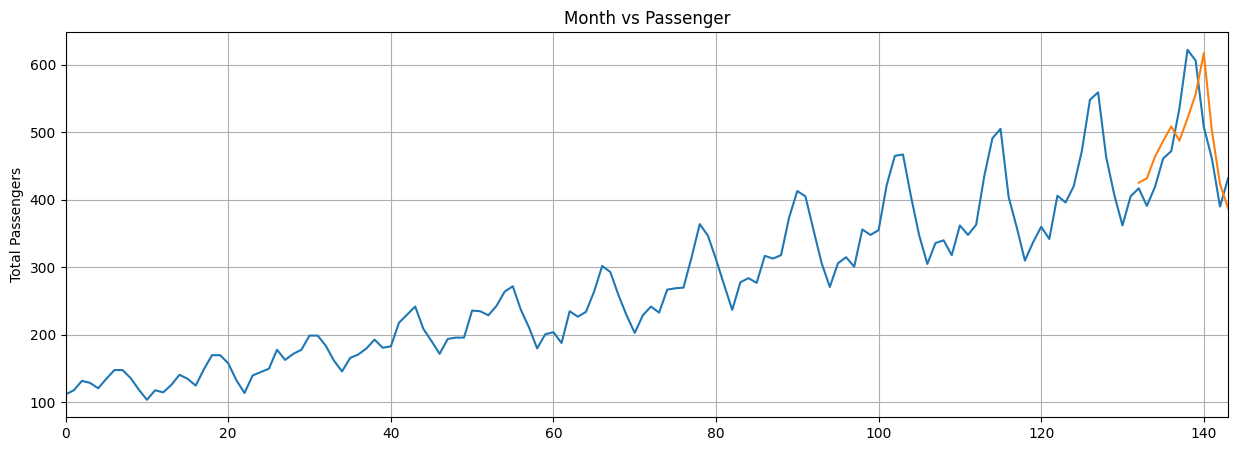

In [72]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

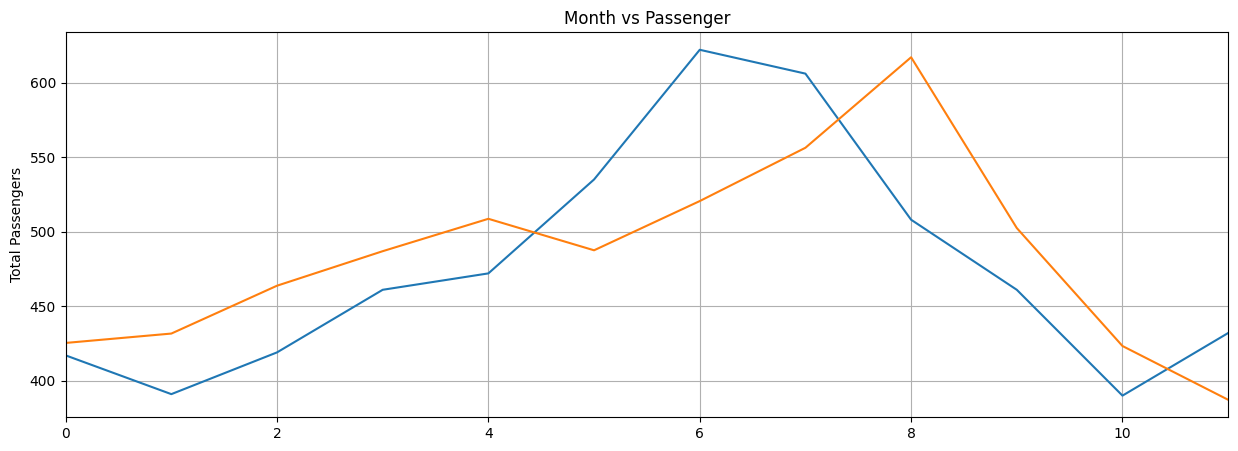

In [73]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test_data)
plt.plot(actual_predictions)
plt.show()

### Exercise 2

1/ The multivariate data includes the daily volume traded, opening price, high price, and low price. The LSTM is trying to predict Bitcoin's price for the next 50 days.

In [77]:
import yfinance as yf

end = pd.to_datetime("today").strftime("%Y-%m-%d")
df = yf.download("BTC-USD", start="2016-01-01", end=end, interval="1d", progress=False)
df.to_csv("btc_usd_daily.csv")  # optional
print(df[['Open','High','Low','Close','Volume']].head())

Price             Open        High         Low       Close    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2016-01-01  430.721008  436.246002  427.515015  434.334015  36278900
2016-01-02  434.622009  436.062012  431.869995  433.437988  30096600
2016-01-03  433.578003  433.743011  424.705994  430.010986  39633800
2016-01-04  430.061005  434.516998  429.084015  433.091003  38477500
2016-01-05  433.069000  434.182007  429.675995  431.959991  34522600


C:\Users\haina\AppData\Local\Temp\ipykernel_20804\2608298416.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2016-01-01", end=end, interval="1d", progress=False)


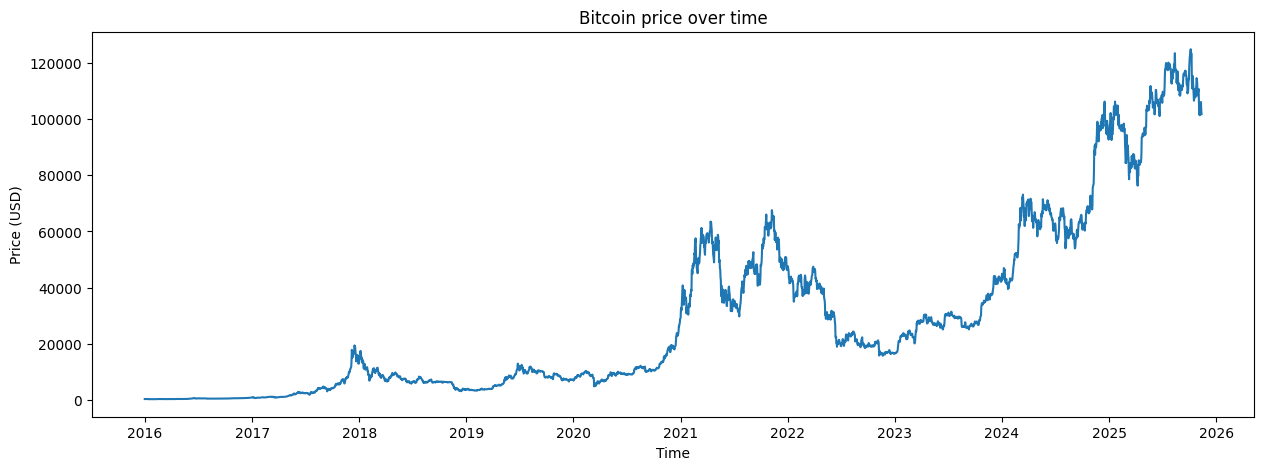

In [78]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.show()